# Double Dot

This notebook will be used to develop a model for transport in double dots. The focus is to obtained honeycomb charge stability diagrams and current at triple points.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.special # for expit function
import scipy.integrate
import time
import mpmath
import itertools
import networkx as nx

## Potential Profile

The device is assumed to extend from -100 to 100 nm. 5 gates are present.

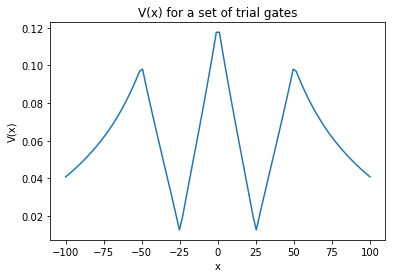

In [9]:
def calc_V_gate(x,param):
    '''
    param = [peak,mean,h,rho,screen]
        peak : value of V at x = mean
        mean : central position of the gate
        h : height of the gate above the 2DEG
        rho : radius of the cylindrical gate
        screen : screening length in the 2DEG
        
    V(x-mean) = peak/log(h/rho) * log(sqrt(h^2 + x^2)/rho) * exp(-|x|/screen)
    '''
    (peak,mean,h,rho,screen) = param
    dx = np.abs(x-mean)
    return (peak/np.log(h/rho))*np.log(np.sqrt(dx**2 + h**2)/rho)*np.exp(-dx/screen)

N_grid = 100
x = np.linspace(-100,100,N_grid,endpoint=True)

# trial potential profile
param1 = [150e-3,-50,50,5,50]
param2 = [-200e-3,-25,50,5,50]
param3 = [250e-3,0,50,5,50]
param4 = [-200e-3,25,50,5,50]
param5 = [150e-3,50,50,5,50]
trial_gates = [param1,param2,param3,param4,param5] 

V = np.sum([calc_V_gate(x,p) for p in trial_gates],axis=0)

plt.plot(x,V)
plt.xlabel('x')
plt.ylabel('V(x)')
plt.title("V(x) for a set of trial gates");

In [344]:
class ThomasFermi():
    '''
    Thomas-Fermi routines based on the polylog function approach.
    
    '''
    def __init__(self,physics):
        '''
        physics is a dict with the revelant physics
        
        x : 1d grid 
        V : potential profile
        K_0 : strength of the Coulomb interaction
        sigma : softening paramter for Coulomb interaction matrix
        mu : chemical potential (assumed to be equal for both leads)
        D : dimension of the problem to be used in the electron density integral
        g_0 : coefficient of the density of states
        kT : temperature of the system, required for the Fermi integral
        '''
        self.physics = physics
        self.K_mat = self.calc_K_mat()
        self.state = ""
        self.physics['mu_L'] = 0.5*self.physics['bias']
        self.physics['mu_R'] = - 0.5*self.physics['bias']

    def calc_K_mat(self):
        x = self.physics['x']
        K_0 = self.physics['K_0']
        sigma = self.physics['sigma']
        
        dx = np.sqrt((x - x[:,np.newaxis])**2 + sigma**2)
        # sigma in the numerator is added for normalisation, so that value at x = 0 is same irrespective of change
        # in sigma
        self.K_mat = K_0*sigma/dx
        return self.K_mat

    def calc_n(self):
        V = self.physics['V']
        K_mat = self.K_mat
        D = self.physics['D']
        g_0 = self.physics['g_0']
        beta = self.physics['beta']
        mu = self.physics['mu']
        
        def polylog_f(x):
            np_polylog = np.frompyfunc(mpmath.polylog, 2, 1)
            output = -g_0*np_polylog(D-1,-np.exp(beta*x))
            # cast from mpc array to numpy array
            return np.array(list(map(lambda x : complex(x),output)))
        
        n = np.zeros(len(V))
        n_prev = np.zeros(len(V))
        phi = np.zeros(len(V))
        
        for i in range(100):
            # turn on the Coulomb over 10 steps
            if i < 10:
                phi = (i/10) * np.dot(self.K_mat,n)
            n_prev = n
            n = polylog_f(mu - V + phi)

            if (i > 10) and (np.linalg.norm(n - n_prev)**2 < (1e-12) * np.linalg.norm(n) * np.linalg.norm(n_prev)):
                #print("Done in",i)
                break;
        self.n = np.real(n)
        return self.n

    def calc_islands(self):
        n = self.n
        # adaptive eps makes the calculation more robust 
        n_eps = 1e-1*np.max(n)
        
        n_chop = np.array([x if x > n_eps else 0.0 for x in n])
        islands = []
        start = False
        islands_index = 0
        left = 0
        for i in range(len(n_chop)):
            if(n_chop[i] > 0.0 and not start):
                start = True
                left = i
            if(n_chop[i] == 0.0 and start):
                start = False
                islands.append([left,i - 1])
                islands_index += 1
            if((i == (len(n_chop) - 1)) and start):
                start = False
                islands.append([left,i])
                islands_index += 1
       
        # has to be copy since I will be popping off elemets from the islands list
        self.all_islands = islands.copy()
        # ignore the leads
        # in case the leads are absent, their absence is ignored
        
        # if left and right leads are present lead is present
        if(len(islands) == 1):
            # short-circuit condition
            islands.pop(0)
            self.state = "ShortCircuit"
        elif(islands[0][0] == 0 and islands[-1][1] == len(n) - 1):
            islands.pop(0)
            islands.pop(-1)
        
        self.islands = islands
        return self.islands
    
    def calc_barriers(self):
        '''
            Calculates the locations of the barriers once the self.islands dictionary has been set. 
            The start and end locations are inclusive.
        '''
        self.barriers = []
        for i in range(len(self.all_islands)-1):
            bar_start = self.all_islands[i][1] + 1
            bar_end = self.all_islands[i+1][0] - 1
            self.barriers.append([bar_start,bar_end])
        
        return self.barriers
    
    def calc_WKB_prob(self):
        '''
        For each barrier, WKB probability can be defined. A vector of these probabilies is calculated and 
        stored as self.p_WKB.
        '''
       
        self.p_WKB = []
        
        V = self.physics['V']
        mu = self.physics['mu']
        WKB_coeff = self.physics['WKB_coeff']
       
        # in order to handle negative values near the boundaries, I have put in abs
        k = WKB_coeff*np.sqrt(np.abs(V + np.dot(self.K_mat,self.n) - mu))
        for i in range(len(self.barriers)):
            bar_start = self.barriers[i][0]
            bar_end = self.barriers[i][1]
            prob = np.exp(-2*scipy.integrate.simps(k[bar_start:(bar_end + 1)],x[bar_start:(bar_end + 1)]))
            
           
            self.p_WKB.append(prob)
            
        # calculate attempt rates only if islands are present
        if(len(self.islands) >= 1):
            attempt_rate = []
            for i in range(len(self.islands)):
                island_start = self.islands[i][0]
                island_end = self.islands[i][1]
                # classical round trip time
                attempt_time = 2*(island_end - island_start + 1)*(self.physics['x'][1]-self.physics['x'][0])\
                        *1/np.sqrt(mu)*self.physics['attempt_rate_coef'] 
                rate = 1/attempt_time
                attempt_rate.append(rate)
            # include for leads as well
            attempt_rate_vec = np.array([attempt_rate[0]] + attempt_rate)
            self.p_WKB = attempt_rate_vec*self.p_WKB
        return self.p_WKB
        
    def calc_charges(self):
        n = self.n
        islands = self.islands
        
        charges = []
        for item in islands:
            charges.append(np.sum(n[item[0]:(item[1] + 1)]))
        
        self.charges = np.array(charges)

        return self.charges

    def calc_cap_model(self):
        islands = self.islands
        n = self.n

        # list of charge densities for islands
        n_list = []
        for item in islands:
            n_island = np.zeros(len(n))
            n_island[item[0]:(item[1]+1)] = n[item[0]:(item[1] + 1)] 
            n_list.append(n_island)
            
        V = self.physics['V']
        c_k = self.physics['c_k']
        mu = self.physics['mu']
        Z = self.charges
        
        def cap_func(i,j):
            energy = 0.0
            if i == j:
                energy += c_k*np.sum(n_list[i]*n_list[i]) 

            energy += 0.5*np.dot(np.dot(n_list[i].T,self.K_mat),n_list[j])
            return energy

        energy_matrix = np.array([(1.0/((Z[i]*Z[j]) + 1e-6))*cap_func(i,j) for i in range(len(n_list)) for j in range(len(n_list))])\
        .reshape((len(n_list),len(n_list)))

        inverse_cap_matrix = energy_matrix
    
        cap_model = (Z,inverse_cap_matrix)
        self.cap_model = cap_model
        
        # cheap cap model for checking my markov chain calculations
        #if (len(self.islands) == 1):
        #    self.cap_model = (Z,np.array([0.01]))
        #elif (len(self.islands) == 2):
        #    self.cap_model = (Z,np.array([[0.01,0.001],[0.001,0.01]]))
        
        return self.cap_model 

    def calc_cap_energy(self,N_vec):
        N_vec = np.array(N_vec)
        cap_model = self.cap_model
        
        return 0.5*np.dot(np.dot((N_vec-cap_model[0]),cap_model[1]),(N_vec-cap_model[0]).T)
    
    def calc_stable_config(self):
        (Z,inverse_cap_matrix) = self.cap_model 

        N_int = [int(np.rint(x)) for x in Z]
        N_limit = 1
        dN_list = [range(max(0,x-N_limit),x+N_limit+1,1) for x in N_int] 
        N_list = list(itertools.product(*dN_list))

        energy_table = [self.calc_cap_energy(np.array(x)) for x in N_list]
        min_energy = min(energy_table)
        charge_configuration = N_list[energy_table.index(min_energy)]
        self.charge_configuration = np.array(charge_configuration)

        return self.charge_configuration

    def fermi(self,E):
        '''
        Input:
            E : energy (eV)

        Output:
            fermi_function
        '''
        kT = self.physics['kT']
        return scipy.special.expit(-E/kT)
    
    def dfermi(self,E):
        '''
        Derivative of the Fermi function
        '''
        kT = self.physics['kT']
        dfermi = scipy.special.expit(-E/kT)**2 * (1/kT) * np.exp(-E/kT)
        return dfermi
    
    def calc_weight(self,u,v):
        '''
        Takes in two nodes u and v and calculates the weight to go from u to v
        '''
        diff = list(np.array(v) - np.array(u))
        E_u = self.calc_cap_energy(np.array(u))
        E_v = self.calc_cap_energy(np.array(v))
      
        mu_L = self.physics['mu_L']
        mu_R = self.physics['mu_R']
        if(len(self.islands) == 1):
            if diff in [[1.0]]:
                weight = self.p_WKB[0]*self.fermi(E_v - E_u - mu_L) + self.p_WKB[1]*self.fermi(E_v - E_u - mu_R)
            elif diff in [[-1.0]]:
                weight = self.p_WKB[0]*(1-self.fermi(E_u - E_v - mu_L)) + self.p_WKB[1]*(1-self.fermi(E_u - E_v - mu_R))
            else:
                weight = 0.0
        elif(len(self.islands) == 2):
            if diff in [[1,0]]:
            #transport onto the dots
                weight = self.p_WKB[0]*self.fermi(E_v - E_u - mu_L)
            elif diff in [[0,1]]:
                weight = self.p_WKB[2]*self.fermi(E_v - E_u - mu_R)
            elif diff in [[-1,0]]:
            #transport out of the dots
                weight = self.p_WKB[0]*(1-self.fermi(E_u - E_v - mu_L)) 
            elif diff in [[0,-1]]:
                weight = self.p_WKB[2]*(1-self.fermi(E_u - E_v - mu_R))
            elif diff in [[-1,1]]:
            #transport between the dots
                weight = self.p_WKB[1]*self.fermi(E_v-E_u - mu_L) 
            elif diff in [[1,-1]]:
                weight = self.p_WKB[1]*self.fermi(E_v-E_u - mu_R) 
            else:
                weight = 0.0
            
        return weight
            
        
    def create_graph(self):
        '''
        Creates the Markov graph assuming the least energy configuration as the starting node node.
        '''
        self.G = nx.DiGraph()
       
        self.start_node = tuple(self.charge_configuration)
        self.G.add_node(self.start_node)
        # single dot
        if (len(self.islands) == 1):
            self.G.add_node(tuple(np.array(self.start_node) + 1))
            self.G.add_node(tuple(np.array(self.start_node) - 1))

        #double dot
        elif (len(self.islands) == 2):
            self.G.add_node(tuple(np.array(self.start_node) + [1,0]))
            self.G.add_node(tuple(np.array(self.start_node) + [-1,0]))
            self.G.add_node(tuple(np.array(self.start_node) + [0,1]))
            self.G.add_node(tuple(np.array(self.start_node) + [0,-1]))
            self.G.add_node(tuple(np.array(self.start_node) + [1,1]))
            self.G.add_node(tuple(np.array(self.start_node) + [-1,-1]))
            self.G.add_node(tuple(np.array(self.start_node) + [1,-1]))
            self.G.add_node(tuple(np.array(self.start_node) + [-1,1]))
            
            for node in self.G.nodes():
                if node[0] < 0 or node[1] < 0:
                    self.G.remove_node(node)
        for x in self.G.nodes():
            for y in self.G.nodes():
                self.G.add_edge(x,y,weight=self.calc_weight(x,y))
        return
    
    def calc_stable_dist(self):
        # Adjacency matrix, caution not the Markov matrix
        self.A = np.array(nx.to_numpy_matrix(self.G))
        
        # look at this carefully
        M =  self.A.T - np.diag(np.sum(self.A,axis=1))
        
        # new approach to find the normalised probability distribution, rows of M are linearly dependent, 
        # instead replace last row with a prob normalisation condition
        M_solver = np.append(M[:-1,:],[np.ones(M.shape[0])]).reshape(M.shape) 
        b = np.zeros(M.shape[0])
        b[-1] = 1
        
        self.dist = np.linalg.solve(M_solver,b)
        
        return self.dist
    
    def calc_graph_charge(self):
        if (self.state != "ShortCircuit"):
            max_index = np.argmax(self.dist)
            return self.G.nodes()[max_index]
        else:
            return 0.0
    
    def calc_graph_current(self):
        mu_L = self.physics['mu_L']
        mu_R = self.physics['mu_R']
        if(len(self.islands) == 1):
            current = 0.0
            u = self.start_node
            E_u = self.calc_cap_energy(np.array(u))

            plus = tuple(np.array(self.start_node) + 1)
            E_plus = self.calc_cap_energy(np.array(plus))
            GammaL_Nplus = self.p_WKB[0]*self.fermi(E_plus - E_u - mu_L)
            GammaL_Nplus_r = self.p_WKB[0]*(1 - self.fermi(E_plus - E_u - mu_L))

            minus = tuple(np.array(self.start_node) - 1)
            E_minus = self.calc_cap_energy(np.array(minus))
            GammaL_Nminus = self.p_WKB[0]*self.fermi(E_u - E_minus - mu_L)
            GammaL_Nminus_r = self.p_WKB[0]*(1 - self.fermi(E_u - E_minus - mu_L))

            index_start_node = self.G.nodes().index(self.start_node)
            index_plus = self.G.nodes().index(plus)
            index_minus = self.G.nodes().index(minus)
            current = self.dist[index_minus]*GammaL_Nminus \
                           + self.dist[index_start_node]*(GammaL_Nplus - GammaL_Nminus_r) \
                           -  self.dist[index_plus]*GammaL_Nplus_r
            self.current = current
        elif(len(self.islands) == 2):
            current = 0
            for edge in self.G.edges():
                (u,v) = edge
                diff = list(np.array(v) - np.array(u))
                if diff in [[1,0]]:
                    E_u = self.calc_cap_energy(np.array(u))
                    E_v = self.calc_cap_energy(np.array(v))
                    
                    Gamma = self.p_WKB[0]*self.fermi(E_v - E_u - mu_L)
                    index = self.G.nodes().index(u)
                    current += Gamma*self.dist[index]
                elif diff in [[-1,0]]:
                    E_u = self.calc_cap_energy(np.array(u))
                    E_v = self.calc_cap_energy(np.array(v))
                    
                    Gamma = self.p_WKB[0]*(1 - self.fermi(E_u - E_v - mu_L))
                    index = self.G.nodes().index(u)
                    current += -1.0*Gamma*self.dist[index]
                else:
                    current += 0
            self.current = current
                    
        return self.current
        
    def calc_current(self):
        #Short circuit
        if self.state == "ShortCircuit":
            return self.physics['ShortCircuitCurrent']
        
        #single barrier
        elif len(self.islands) == 0:
            I = self.p_WKB[0] * self.physics['barrier_tunnel_rate']*self.dfermi(self.physics['bias'])*self.physics['bias']
            
        # else dots
        else:
            self.create_graph()
            self.calc_stable_dist()
            I = self.calc_graph_current()
            
        return I
        


islands [[18, 48], [51, 81]]
barriers [[5, 17], [49, 50], [82, 94]]
WKB Probability [  8.26003403e-16   7.05104754e-05   8.26003403e-16]
charges [ 36.30078627  36.30078627]
cap_model (array([ 36.30078627,  36.30078627]), array([[ 0.00106709,  0.00022481],
       [ 0.00022481,  0.00106709]]))
stable_config [36 36]
current 1.74504826405e-21
graph charge (36, 36)


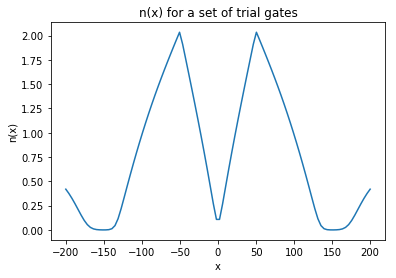

In [350]:
x = np.linspace(-200,200,100)

# trial potential profile
param1 = [200e-3,-150,50,5,50]
param2 = [-140e-3,-50,50,5,50]
param3 = [250e-3,0,50,5,50]
param4 = [-140e-3,50,50,5,50]
param5 = [200e-3,150,50,5,50]
trial_gates = [param1,param2,param3,param4,param5] 

V = np.sum([calc_V_gate(x,p) for p in trial_gates],axis=0)

physics = {'x' : x,
           'V' : V,
           'K_0' : 5e-3, 
           'sigma' : 10.0,
           'mu' : 0.1,
           'D' : 2,
           'g_0' : 1e-1,
           'c_k' : 0e-4,
           'beta' : 100,
           'kT' : 1e-5,
           'WKB_coeff' : 1,
           'barrier_tunnel_rate' : 1.0,
           'bias' : 1e-5,
           'ShortCircuitCurrent' : 1.0,
           'attempt_rate_coef' : 1
           }

tf = ThomasFermi(physics)
n = tf.calc_n()
islands = tf.calc_islands()
barriers = tf.calc_barriers()
p_WKB = tf.calc_WKB_prob()
charges = tf.calc_charges()
cap_model = tf.calc_cap_model()
stable_config = tf.calc_stable_config()
current = tf.calc_current()
graph_charge = tf.calc_graph_charge()

print("islands",islands)
print("barriers",barriers)
print("WKB Probability",p_WKB)
print("charges",charges)
print("cap_model",cap_model)
print("stable_config",stable_config)
print("current",current)
print("graph charge",graph_charge)


plt.plot(x,n)
plt.xlabel('x')
plt.ylabel('n(x)')
plt.title("n(x) for a set of trial gates");

In [278]:
N_v = 20
Vd1_vec = np.linspace(-170e-3,-150e-3,N_v)
Vd2_vec = np.linspace(-170e-3,-150e-3,N_v)

# list_list_b is a list of the possible set of gate voltages which is later converted into a potential profile
list_list_b = [[param1,param3,param5] + [[a,-50,50,5,50],[b,50,50,5,50]] for a in Vd1_vec for b in Vd2_vec]

def calc_V(x,y):
    return np.sum([calc_V_gate(x,p) for p in y],axis=0)

st = time.time()
tf = ThomasFermi(physics) 

def wrapper(V):
    tf.physics['V'] = V 
    n = tf.calc_n()
    islands = tf.calc_islands()
    barriers = tf.calc_barriers()
    p_WKB = tf.calc_WKB_prob()
    charges = tf.calc_charges()
    cap_model = tf.calc_cap_model()
    stable_config = tf.calc_stable_config()
    current = tf.calc_current()
    charge = tf.calc_graph_charge()
    
    #return np.rint(charges)
    #return stable_config
    return current

charge_config = [wrapper(calc_V(x,y)) for y in list_list_b]
print("Time",time.time()-st)

XX,YY = np.meshgrid(Vd1_vec,Vd2_vec)
plt.pcolor(XX,YY,np.array([np.sum(x) for x in charge_config]).reshape((N_v,N_v)));
plt.xlabel('V_d1')
plt.ylabel('V_d1')
cbar = plt.colorbar()
cbar.set_label("Total Charge")
plt.title('Charge Stability Diagram')

KeyboardInterrupt: 

Time 11.024837017059326


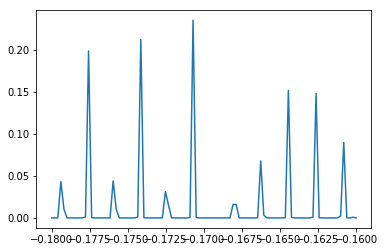

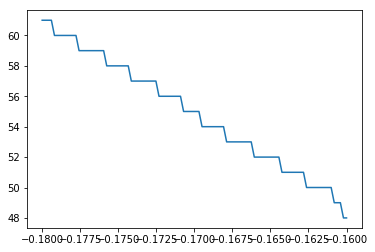

In [297]:
# diagonal trace
N_v = 100
V_d_vec = np.linspace(-140e-3,-180e-3,N_v)

# list_list_b is a list of the possible set of gate voltages which is later converted into a potential profile
list_list_b = [[param1,param3,param5] + [[a,-50,50,5,50],[a,50,50,5,50]] for a in V_d_vec] 

def calc_V(x,y):
    return np.sum([calc_V_gate(x,p) for p in y],axis=0)

st = time.time()
tf = ThomasFermi(physics) 

def wrapper(V):
    tf.physics['V'] = V 
    n = tf.calc_n()
    islands = tf.calc_islands()
    barriers = tf.calc_barriers()
    p_WKB = tf.calc_WKB_prob()
    charges = tf.calc_charges()
    cap_model = tf.calc_cap_model()
    stable_config = tf.calc_stable_config()
    current = tf.calc_current()
    charge = tf.calc_graph_charge()
    
    return current,charge 

res = [wrapper(calc_V(x,y)) for y in list_list_b]
print("Time",time.time()-st)

plt.figure(1)
plt.plot(V_d_vec,np.array([np.sum(x[0]) for x in res]))
plt.figure(2)
plt.plot(V_d_vec,np.array([np.sum(x[1]) for x in res]))

In [166]:
%pdb

Automatic pdb calling has been turned OFF


Time 4424.356544017792


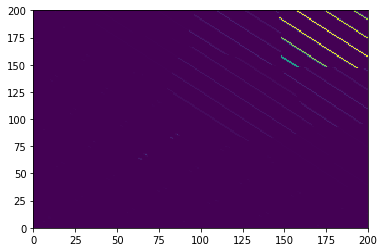

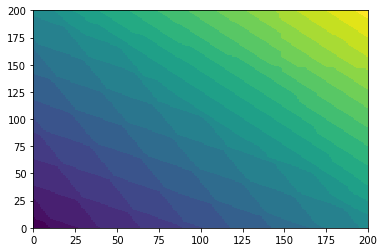

In [346]:
N_v = 200
V_d1_vec = np.linspace(-140e-3,-180e-3,N_v)
V_d2_vec = np.linspace(-140e-3,-180e-3,N_v)

import ipyparallel as ipp
rc = ipp.Client()
# list_list_b is a list of the possible set of gate voltages which is later converted into a potential profile
list_list_b = [[param1,param3,param5] + [[a,-50,50,5,50],[b,50,50,5,50]] for a in V_d1_vec for b in V_d2_vec]

def calc_V(x,y):
    return np.sum([calc_V_gate(x,p) for p in y],axis=0)

st = time.time()
tf = ThomasFermi(physics) 

def wrapper(V):
    tf.physics['V'] = V 
    n = tf.calc_n()
    islands = tf.calc_islands()
    barriers = tf.calc_barriers()
    p_WKB = tf.calc_WKB_prob()
    charges = tf.calc_charges()
    cap_model = tf.calc_cap_model()
    stable_config = tf.calc_stable_config()
    current = tf.calc_current()
    charge = tf.calc_graph_charge()
    
    return current,charge 

res = [wrapper(calc_V(x,y)) for y in list_list_b]
print("Time",time.time()-st)

plt.figure(1)
plt.pcolor(np.array([np.sum(x[0]) for x in res]).reshape(N_v,N_v))

plt.figure(2)
plt.pcolor(np.array([np.sum(x[1]) for x in res]).reshape(N_v,N_v))


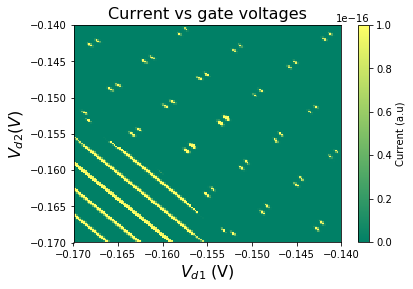

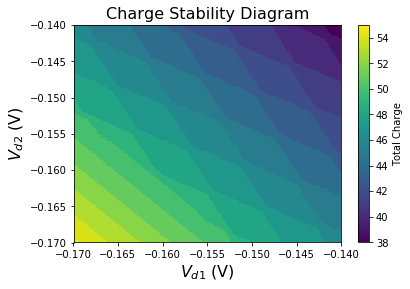

In [349]:
XX,YY = np.meshgrid(V_d1_vec[:150],V_d2_vec[:150])
plt.figure(1)
plt.pcolor(XX,YY,np.array([np.sum(x[0]) for x in res]).reshape(N_v,N_v)[:150,:150],vmax=1e-16,cmap='summer')
plt.xlabel(r'$V_{d1}$ (V)',fontsize=16)
plt.ylabel(r'$V_{d2} (V)$',fontsize=16)
plt.title("Current vs gate voltages",fontsize=16)
cbar = plt.colorbar()
cbar.set_label('Current (a.u)')

plt.figure(2)
plt.pcolor(XX,YY,np.array([np.sum(x[1]) for x in res]).reshape(N_v,N_v)[:150,:150])
plt.xlabel(r'$V_{d1}$ (V)',fontsize=16)
plt.ylabel(r'$V_{d2}$ (V)',fontsize=16)
plt.title("Charge Stability Diagram",fontsize=16)
cbar = plt.colorbar()
cbar.set_label('Total Charge')
